Following code from CPU_ID2.ipynb, add in confounding

In [213]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os, math
import matplotlib.image as mpimg
import torch
import matplotlib as mpl
from skimage import io
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import copy
from sklearn.decomposition import PCA
import seaborn as sns
import torchvision.models as models
import torch.nn.functional as F
from glob import glob
import cv2
from src.utility import preprocess_image, convert_image_np, getImageNetDict, getImageNetCodeDict
import torch.optim as optim
import torch.nn as nn
import copy, time
from torchvision import transforms, utils
import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from collections import Counter
from src.parallel_run import map_parallel
from joblib import Parallel, delayed
import multiprocessing
import os.path
from sklearn.externals import joblib

In [214]:
alexnet = models.alexnet(pretrained=True)
imagenetdict = getImageNetDict()
imagenetcodedict = getImageNetCodeDict()
name2code = dict((v, k) for k, v in imagenetcodedict.items())
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=4096)
    (5): ReLU(inplace)
    (6): Linea

In [215]:
model = copy.deepcopy(alexnet)
model.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
W = list(alexnet.classifier.children())[-1].weight.cpu().data.numpy()
net = alexnet

In [216]:
def to_var(x, *args, **kwargs):
    if type(x) is list or type(x) is tuple:
        x = [Variable(x_, *args, **kwargs) for x_ in x]
    else:
        x = Variable(x, *args, **kwargs)
    return x

# display the basis vectors
def preprocess_im(im, volatile=False, resize_im=True):
    original_image = cv2.imread(im)
    prep_img = preprocess_image(original_image, resize_im=resize_im)
    if volatile:
        prep_img.volatile = True
    return prep_img

def show_image(images, title=''):
    seq = []
    for im in images:
        prep_img = preprocess_im(im, volatile=True)
        seq.append(prep_img)
    images_batch = torch.cat(seq, dim=0)
    grid = utils.make_grid(images_batch.data)   
    plt.imshow(convert_image_np(grid))
    plt.title(title)
    plt.gca().grid(False)
    plt.show()
    
def show_concepts(concepts, n_per_concept=8):
    prefix = 'tiny-imagenet-200/train/'
    res = []
    for c in concepts:
        name = prefix + name2code[c]
        all_pics = glob(name + '/images/*')
        rs = np.random.choice(range(len(all_pics)), n_per_concept, replace=False)
        res.extend([all_pics[r] for r in rs])
    
    plt.figure(figsize=(10,10))
    show_image(res)
    plt.show()
    
def generate_basis(concept_class, W):
    n_per_class = math.ceil(W.shape[1] / len(concept_class))
    prefix = 'tiny-imagenet-200/train/'
    res = []
    concepts = []
    for c in concept_class:
        name = prefix + name2code[c]
        all_pics = glob(name + '/images/*')
        rs = np.random.choice(range(len(all_pics)), n_per_class, replace=False)
        res.extend([all_pics[r] for r in rs])
        concepts.extend([name2code[c] for r in rs])
        
    order = np.random.permutation(W.shape[1])
    res = np.array(res)[order]
    concepts = np.array(concepts)[order]
    return res, concepts

def get_test_images(concept_class, anno_path='tiny-imagenet-200/val'):
    anno = anno_path + '/val_annotations.txt'
    d = {}
    with open(anno) as f:
        for l in f:
            k, v = l.split()[:2]
            d[k] = v
            
    prefix = anno_path + '/images/'
    images = []
    labels = []
    for im in glob(prefix + '*'):
        c = d[im.split('/')[-1]]
        if imagenetcodedict[c] in concept_class:
            images.append(im)
            labels.append(c)
    return images, labels

def predict(net, im):
    net.eval()
    prep_img = preprocess_im(im)
    prediction = net(prep_img).data.cpu().numpy().argmax()
    return imagenetdict[prediction], prediction

def extract_features(net, images):
    net.eval()
    seq = []
    for im in tqdm.tqdm(images):
        prep_img = preprocess_im(im, volatile=True)
        seq.append(prep_img)
        
    features = []
    for i in tqdm.tqdm(range(0, len(seq), 100)):
        images_batch = torch.cat(seq[i:i+100], dim=0)
        features.append(net(images_batch))
    return torch.cat(features, dim=0)

def check_ortho(theta_list, plot=False, verbose=False):
    Q = [t/np.linalg.norm(t) for t in theta_list]
    Q = np.vstack(Q).T
    error = np.sum(np.abs(Q.T.dot(Q) - np.eye(Q.shape[1])))
    if verbose:
        print("orthogonal check error: ", error)
    if plot:
        print(Q.T.dot(Q))
        plt.matshow(Q.T.dot(Q))
        plt.show()
    return error
    
def orthogonize_(theta, prev_theta_list):
    '''goal: theta should be orthogonal to all vectors in prev_theta_list'''
    theta = theta / np.linalg.norm(theta)
    for t in prev_theta_list:
        theta = theta - theta.dot(t) / np.dot(t,t) * t 
    return theta

def orthogonize(theta, prev_theta_list, verbose=False):
    done = len(prev_theta_list) == 0
    while not done:
        theta = orthogonize_(theta, prev_theta_list)
        #check_ortho(prev_theta_list, plot=False)        
        #check_ortho(prev_theta_list + [theta], plot=False)
        #print('in middle', theta)
        #print(check_ortho(prev_theta_list + [theta]))
        #if  check_ortho(prev_theta_list + [theta]) > 1e-3:
            #print(check_ortho(prev_theta_list + [theta]))
        if np.linalg.norm(theta) < 1e-10: # give a random direction to theta to theta too close to 0
            if verbose:
                print('restart a vector')
            theta = np.random.randn(len(theta))
        else:
            done = True
        
    return theta / np.linalg.norm(theta) # to keep theta in a good range for numerical stability

def ortho_inverse(P):
    out = copy.deepcopy(P.T)
    div = np.diag(P.T.dot(P))
    for i, v in enumerate(div):
        out[i] /= v
    return out

def data_range(A, t):
    return A.dot(t/t.dot(t)).ravel().std()

def normalize_theta(A, t):
    drange = data_range(A, t)
    if drange == 0: # no need to normalize
        return t
    return t * drange # multiply so that in P^-1 is divide by

def print_result(W, concepts, errors, threshold=0.1, mask=True):
    coe = W
    print('"*" postfixed means error < %.4f' % threshold)
    print('%15s %10s %10s' % ('concepts', 'coeff', 'error'))
    print('-'*37)
    for w, c, e in sorted(zip(coe, concepts, errors), key=lambda x: abs(x[0]), reverse=True):
        if e < threshold:
            c = c+"*"
        else:
            if mask: c = 'unknown'
        print("%15s %10.4f %10.4f" % (c, w, e))   

def eval_direction(theta, c, l, A, plot=False, verbose=False):
    '''concept c, labels l, activation map A'''
    y = np.zeros(len(l))
    y[np.array(l) == c] = 1
    
    n, d = A.shape
    a = A.dot(theta).ravel()
    X = np.vstack([a, np.ones(n)]).T
    
    #print(X.shape, y.shape)
    
    m, b = np.linalg.lstsq(X, y)[0]
    error = np.mean((X.dot(np.array([m,b])) - y)**2)
    
    if verbose:
        print('%s error: %.4f, slope: %+.4f, intercept: %+4f' % (c.ljust(14), error, m, b))        
    if plot:
        colors = list(map(switch_color, l))
        transformed = X.dot(np.array([m,b]))
        plt.scatter(transformed, transformed + np.random.random(n), c=colors)
        plt.show()
    return error, m, b

def interpret_direction(t, concepts_list, labels, A):
    min_e = 1000
    min_c = ""
    min_m = 0
    for c in concepts_list:
        e, m, b = eval_direction(t, c, labels, A)
        if e < min_e:
            min_e = e
            min_c = c
            min_m = m
    return min_e, min_m, min_c 

def plot_inter_stats(directions, neuron_numbers, concepts, labels, A, plot=True):
    theta_list = []
    errors = []
    used_concepts = []
    for i in tqdm.tqdm(neuron_numbers):
        direction = directions[i]
        e, m, c = interpret_direction(direction, concepts, labels, A) 
        if m < 0:
            direction = -direction
        theta_list.append(direction)
        errors.append(e)
        used_concepts.append(c)

    if plot:
        sns.distplot(errors)
        plt.ylabel('frequency')
        plt.xlabel('interpretable error')
        plt.show()
    return errors, used_concepts

def print_mean_std(errors, name=""):
    m, s = np.mean(errors), np.std(errors)
    print(('%20s mean: %.3f, std: %.4f') % (name, m, s))
    
def concept_scatter(a, concepts, labels):
    for c in concepts:
        a_ = a[labels==c]
        plt.scatter(a_, a_ + np.random.random(len(a_))*3, label=imagenetcodedict[c])
    plt.legend()
    
class LR(nn.Module): # logistic regression with 2 neurons
    def __init__(self, input_size, output_size=2):
        super().__init__()
        
        self.i2o = nn.Linear(input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, input):
        output = self.softmax(self.i2o(input))
        return output

def get_y(c, l, A):
    '''concept c, labels l, activation map A'''
    y = np.zeros(len(l))
    y[np.array(l) == c] = 1
    return y   

def plotEvalDirection(direction, A, l, concepts, c):
    e, m, b = eval_direction(direction, c, l, A)
    if m < 0:
        direction = -direction
    a = A.dot(direction)
    if a.std() != 0:
        a = a / a.std()
    concept_scatter(a, concepts, np.array(l))
    plt.title('%s error: %.4f' % (imagenetcodedict[c], e))    

def plotInterpretDirection(direction, A, l, concepts):
    # plt.figure(figsize=(7,7))
    e, m, c = interpret_direction(direction, concepts, l, A) 
    if m < 0:
        direction = -direction
    a = A.dot(direction)
    if a.std() != 0:
        a = a / a.std()
    concept_scatter(a, concepts, np.array(l))
    plt.title('%s error: %.4f' % (imagenetcodedict[c], e))    
    
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=100, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(to_var(inputs))
            loss = criterion(outputs, to_var(labels))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

def custom_solve(A, y, max_time=3):
    concept_lr_data = TensorDataset(torch.from_numpy(A), torch.from_numpy(y).long())
    trainloader = DataLoader(concept_lr_data, batch_size=32, num_workers=0) # num_workers=0 makes sure can parallelize
    
    concept_net = LR(A.shape[1])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(concept_net.parameters())
    train(concept_net, trainloader, criterion, optimizer, print_every=None, max_time=max_time)   
    
    theta = concept_net.i2o.weight
    theta = (theta[1] - theta[0]).data.numpy()
    return theta

def custom_leastsq_concept(c, l, A, max_time=3):
    '''concept c, labels l, activation map A'''
    y = get_y(c, l, A)
    theta = custom_solve(A, y, max_time=max_time)
    return theta

def number_interpretable(errors, threshold):
    return sum(np.array(errors) < threshold)

def plot_number_interpretable(name, errors, thresholds):
    nums = []
    for t in thresholds:
        nums.append(number_interpretable(errors, t))
    plt.plot(thresholds, nums, 'o-', label=name)
    plt.xlabel('threshold')
    plt.ylabel('#interpretable')

def buildP_greedy(A, concepts_list, labels, A_test, test_labels, threshold, name):

    def data_range(A, t):
        return A.dot(t/t.dot(t)).ravel().std()

    def normalize_theta(A, t):
        drange = data_range(A, t)
        if drange == 0: # no need to normalize
            return t
        return t * drange # multiply so that in P^-1 is divide by
    
    def greedy_find_c(concepts_list, labels, A, A_test, test_labels):

        def inner_loop(c):
            theta = custom_leastsq_concept(c, labels, A)
            error, m, b = eval_direction(theta, c, test_labels, A_test)
            return theta, error, c

        n_cpu = min(int(multiprocessing.cpu_count() / 2), len(concepts_list))
        t_e_c = Parallel(n_jobs=n_cpu)(delayed(inner_loop)(c) for c in concepts_list)
        min_t, min_e, min_c = min(t_e_c, key=lambda x: x[1])
        return min_c, min_t, min_e

    A_backup = copy.deepcopy(A)
    theta_list = []

    fname =  'data/' + name + ("" if name[-4:] == ".npy" else ".npy")
    f_exist = os.path.isfile(fname)
    if f_exist:
        theta_list = np.load(fname)
        f_exist = (len(theta_list) == A.shape[1])
        
    if not f_exist:    
        print('fitting directions......')
        concepts_used = []
        errors = []
        for _ in tqdm.tqdm(range(A.shape[1])):
            min_c, theta, error = greedy_find_c(concepts_list, labels, A, A_test,test_labels)
            concepts_used.append(min_c)
            errors.append(error)
            theta = orthogonize(theta, theta_list) # just make sure theta are orthogonal # note: randomness here
            theta_list.append(theta)
            np.save("data/" + name, theta_list)
            A = A - np.outer(A.dot(theta).ravel(), theta) / np.sum(theta**2) # project data down 1 dimension

    A = copy.deepcopy(A_backup)
    P = np.vstack(theta_list).T

    errors = []
    slopes = []
    min_c = []
    for t in tqdm.tqdm(theta_list):
        e, m, c = interpret_direction(t, concepts_list, test_labels, A_test) 
        errors.append(e)
        slopes.append(m)
        min_c.append(c)

    # decorrelate unknown data using pca
    B = A.dot(ortho_inverse(P).T) # new activation
    A = []
    ind_changed = []
    for i in range(len(P)):
        if errors[i] >= threshold:
            A.append(B[:,i])
            ind_changed.append(i)
    if len(ind_changed) > 0:
        A = np.vstack(A).T
        print('doing pca %d directions need changes......' % len(ind_changed))
        pca = PCA(n_components=A.shape[1]) 
        pca.fit(A) # takes 5 min
        
        P_subset = np.vstack([P[:,i] for i in ind_changed]).T

        pca_comp = P_subset.dot(pca.components_.T) # n_comp x d
        for i, ind in enumerate(ind_changed):
            comp = pca_comp[:,i] 
            theta_list[ind] = comp

    # normalize variance
    print('normalizing variance......')
    A = copy.deepcopy(A_backup)
    theta_list = [normalize_theta(A, t) for t in theta_list]
    
    print('reevaluating direction errors......') 
    errors = []
    slopes = []
    min_c = []
    for t in tqdm.tqdm(theta_list):
        e, m, c = interpret_direction(t, concepts_list, test_labels, A_test) 
        errors.append(e)
        slopes.append(m)
        min_c.append(c)

    theta_list = list(map(lambda x: x[0] * np.sign(x[1]), zip(theta_list, slopes))) 
    P = np.vstack(theta_list).T
    np.save("data/" + name + '_final', theta_list)

    return P, errors, theta_list, min_c

def visContribution(W, predict_id=940, top=10, test_image_name=None, coordinate=True, use_abs=True):
    
    if test_image_name is not None:
        word, predict_id = predict(net, test_image_name)
        print(word, predict_id)
    else:
        word = imagenetdict[predict_id]

    # an example explaination: W 1000 x num_basis
    weights = W[predict_id]

    if test_image_name is not None:
        b = extract_features(model, [test_image_name])[0].data.cpu().numpy()
        x = lst_solve(A, b)
        if coordinate:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(x)
        else:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(weights * x)
        args = np.argsort(criteria)[::-1]
    else:
        if not use_abs:
            args = np.argsort(weights)[::-1]
        else:
            args = np.argsort(np.abs(weights))[::-1]

    # visualize
    selection = args[:top]
    print('%s =' % word)

    theta = weights[selection]
    images = np.array(basis)[selection]
    
    if test_image_name is not None:
        input_weights = x[selection]
        original_image = cv2.imread(test_image_name)
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.imshow(correct_color_image)
        plt.axis('off')
        plt.title('this image =')
        plt.show()
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, predict_id = predict(net, images[i])
        word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        col.set_title(theta[i])
        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
     
        if test_image_name is not None:
            if coordinate:
                col.set_title(input_weights[i])                
            else:
                col.set_title(theta[i] * input_weights[i])
            col.set_ylabel('%.2f * %.2f' % (theta[i], input_weights[i]))
    plt.show()

def visW(W, A, predict_id=940, top=10, test_image_name=None, coordinate=True, use_abs=True):
    
    if test_image_name is not None:
        word, predict_id = predict(net, test_image_name)
        print(word, predict_id)
    else:
        word = imagenetdict[predict_id]

    # an example explaination: W 1000 x num_basis
    weights = W[predict_id]

    if test_image_name is not None:
        b = extract_features(model, [test_image_name])[0].data.cpu().numpy()
        x = lst_solve(A, b)
        if coordinate:
            if not use_abs:
                criteria = x
            else:
                criteria = np.abs(x)
        else:
            if not use_abs:
                criteria = weights * x
            else:
                criteria = np.abs(weights * x)
        args = np.argsort(criteria)[::-1]
    else:
        if not use_abs:
            args = np.argsort(weights)[::-1]
        else:
            args = np.argsort(np.abs(weights))[::-1]

    # visualize
    selection = args[:top]
    print('%s =' % word)

    theta = weights[selection]
    
    # images: of max activation along each direction
    W_order = np.argmax(A, axis=0)[:len(basis)]
    W_basis = np.array(basis)[W_order]
    images = np.array(W_basis)[selection]
    
    if test_image_name is not None:
        input_weights = x[selection]
        original_image = cv2.imread(test_image_name)
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.imshow(correct_color_image)
        plt.axis('off')
        plt.title('this image =')
        plt.show()
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, predict_id = predict(net, images[i])
        word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        col.set_title(theta[i])
        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
     
        if test_image_name is not None:
            if coordinate:
                col.set_title(input_weights[i])                
            else:
                col.set_title(theta[i] * input_weights[i])
            col.set_ylabel('%.2f * %.2f' % (theta[i], input_weights[i]))
    plt.show()
    
def visW_inter(W, A, image_names, class_id, inter_errors, inter_concepts, output_names=imagenetdict, 
               threshold=None, top=10, reverse=False):
    '''Interpretable version to visualize W, A is the activation for showing image
       If reverse, sort from smallest to largest, else default form largest to smalles
       
       class_id: the row to take
       output_names: what are the names of the rows, default to imagenet dictionary
       top: show top few images
       image_names: image names for each row of A
       inter_errors: interpretability errors of each dimension, should be a vector
       inter_concepts: interpretability concepts for each dimension
    '''
    
    word = output_names[class_id]
    weights = W[class_id]

    args = np.argsort(weights)
    if not reverse:
        args = args[::-1]

    args_order = list(range(1, len(args)+1))
    if threshold is not None:
        new_args = list(filter(lambda x: inter_errors[x] <= threshold, args))
        if len(new_args) >= top: # show enough images
            args_order = list(filter(lambda x: inter_errors[args[x-1]] <= threshold, args_order))
            args = new_args
    selection = args[:top]

    # visualize
    print('%s =' % word)
    theta = weights[selection]
    
    # images of max activation for each neuron activation 
    W_order = np.argmax(A, axis=0)
    images = np.array(image_names)[W_order]
    images = np.array(images)[selection]
    inter_errors = np.array(inter_errors)[selection]
    inter_concepts = np.array(inter_concepts)[selection]
    
    ncols = min(top, len(images))
    fig, ax = plt.subplots(ncols=ncols)
    #fig.set_figheight(10)
    #fig.set_figwidth(20)

    for i, col in enumerate(ax):
        original_image = cv2.imread(images[i])
        correct_color_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        col.imshow(correct_color_image)
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        #word, class_id = predict(net, images[i])
        #word = imagenetcodedict[images[i].split('/')[-1].split('_')[0]]
        word = imagenetcodedict[inter_concepts[i]]

        color = 'blue' if args_order[i] > 3 * top else 'black'
        col.set_title("%.2f (%d)" % (theta[i], args_order[i]), color=color)
            
        color = 'red' if inter_errors[i] > threshold else 'black'        
        col.set_ylabel("%.4f" % inter_errors[i], color=color)

        col.set_xlabel(word[:18]) # set character max to avoid occluding the visualization
    plt.show()
    
def save2disk(dataloader, model, path):
    model.eval()
    os.system('rm %s/*' % path)
    i = 0
    for x, y in tqdm.tqdm(dataloader):
        frozen_input = model(to_var(x)).cpu().data.numpy()
        output = y.numpy()
        for feature, o in zip(frozen_input, output):
            joblib.dump([feature, o], '%s/%d.pkl' % (path,i))
            i += 1
    
def show_acc(net, loader, name=""):
    net.eval()
    correct = 0
    total = 0

    for data in loader:
        x, y = data
        x, y = to_var(x), to_var(y)
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y.data).sum()

    print('Accuracy of the network on %d %s images: %d %%' % (len(loader.sampler), name, 100 * correct / total))

In [217]:
class TinyImagenetTrainDataset(Dataset):
    
    def __init__(self, output_names, basedir='tiny-imagenet-200/train/', transform=None):
        '''
        output_names: names of the output classes
        '''
        self.output_names = output_names
        self.output_ids = [name2code[o] for o in output_names]
        self.basedir = basedir
        self.transform = transform
        
        image_names = []
        image_labels = []
        for i, oid in enumerate(self.output_ids):
            new_fn = glob(basedir + '/' + oid + '/images/*')
            image_names.extend(new_fn)
            image_labels.extend([i] * len(new_fn))
        self.image_names = image_names
        self.image_labels = image_labels
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        name, y = self.image_names[idx], self.image_labels[idx]
        x = cv2.imread(name) # note io.imread doesn't handle gray scale image
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            try:
                x, y = self.transform([x, y])
            except:
                print(name, x.shape)
                plt.imshow(x)
                plt.gca().grid('off')
                plt.show()
                raise
        
        return x, y
    
class TinyImagenetTestDataset(Dataset):
    
    def __init__(self, output_names, basedir='tiny-imagenet-200/val/', transform=None):
        '''
        output_names: names of the output classes
        '''
        self.output_names = output_names
        self.output_ids = [name2code[o] for o in output_names]
        self.basedir = basedir
        self.transform = transform
        
        
        self.image_names, label_ids = get_test_images(output_names, anno_path=basedir)
        self.image_labels = [self.output_ids.index(l) for l in label_ids]
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        name, y = self.image_names[idx], self.image_labels[idx]
        x = cv2.imread(name) # note io.imread doesn't handle gray scale image
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            try:
                x, y = self.transform([x, y])
            except:
                print(name, x.shape)
                plt.imshow(x)
                plt.gca().grid('off')
                plt.show()
        
        return x, y

def show_tensor_image(images_batch):
    grid = utils.make_grid(images_batch)   
    plt.imshow(convert_image_np(grid))
    plt.gca().grid(False)
    plt.show()

class SavedDataset(Dataset): # dataset get saved to disk
    
    def __init__(self, basedir='retrain_data/train'):
        self.items = glob(basedir + '/*')
        
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x, y = joblib.load(self.items[idx])
        return torch.from_numpy(x).float(), y
    
class Resize():
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, x):
        return cv2.resize(x, tuple(self.size))

class MLP(nn.Module): # two layer mlp

    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)
    
# normalize W_modified
def normalize_W_activations(W, A):
    theta_list = []
    W_P = np.eye(W.shape[1])
    for i in tqdm.tqdm(range(W_P.shape[1])):
        t = W_P[:,i]
        theta_list.append(normalize_theta(A, t))
    W_P = np.vstack(theta_list).T
    return W_P

def get_A_and_ids(model, concept_names): # labels are imagenet id
    train_data = TinyImagenetTrainDataset(concept_names)
    test_data = TinyImagenetTestDataset(concept_names)

    print('extracting train labels')
    features_train = extract_features(model, train_data.image_names)
    print('extracting test labels')
    features_test = extract_features(model, test_data.image_names)

    A_train = features_train.data.cpu().numpy()
    A_test = features_test.data.cpu().numpy()

    label_ids_train = [train_data.output_ids[l] for l in train_data.image_labels]
    label_ids_test = [test_data.output_ids[l] for l in test_data.image_labels]
    
    return A_train, label_ids_train, train_data.image_names, A_test, label_ids_test, test_data.image_names


# cat, dog, and watch

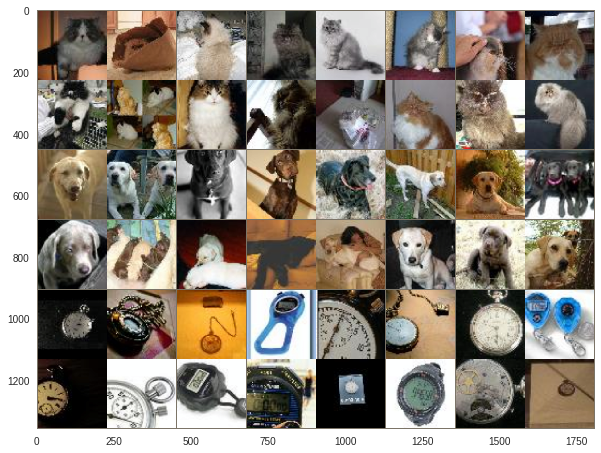

In [220]:
output_names = ['Persian_cat', 'Labrador_retriever'] 
concept_names = ['Persian_cat', 'Labrador_retriever', 'stopwatch']
concept_ids = [name2code[o] for o in concept_names]
num_classes = len(output_names)

show_concepts(concept_names, n_per_concept=16)

label 0
(64, 64, 3)


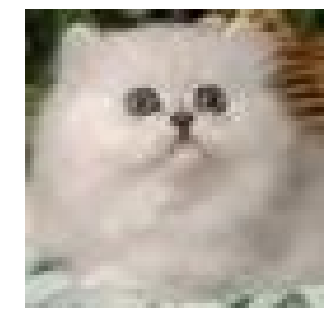

label 1
(64, 64, 3)


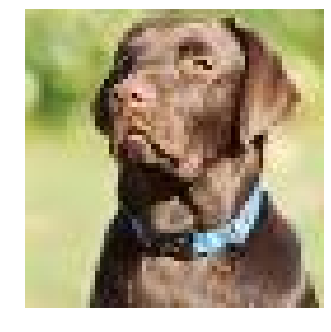

label 2
(64, 64, 3)


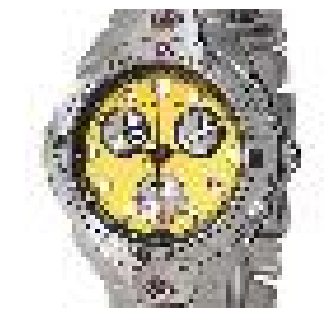

In [219]:
# choose 3 images as example
data = TinyImagenetTrainDataset(concept_names)

im_cat_index = 333
im_cat_path = data.image_names[im_cat_index]
x, y = data[im_cat_index]
print('label', y)
print(x.shape)
plt.imshow(x)
plt.gca().axis('off')
plt.show()

im_dog_index = 580
im_dog_path = data.image_names[im_dog_index]
x, y = data[im_dog_index]
print('label', y)
print(x.shape)
plt.imshow(x)
plt.gca().axis('off')
plt.show()


im_watch_index = 1018
im_watch_path = data.image_names[im_watch_index]
im_watch, y = data[im_watch_index]
print('label', y)
print(im_watch.shape)
plt.imshow(im_watch)
plt.gca().axis('off')
plt.show()



(156, 156, 3)
(68, 68, 3)


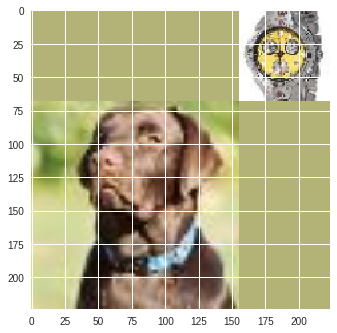

In [127]:
# take 2 images and blend them together
def blend(im1_path, im2_path, im1_ratio=0.7, target_size=(224,224)):
    '''blend the background: break the image into 4 quadrants
    0|1
    ---
    2|3
    '''
    def process_im(im_path, w, h):
        im = cv2.imread(im_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = np.float32(cv2.resize(im, (h, w)))
        print(im.shape)
        for channel in range(3):
            im[:,:,channel] /= 255
        return im 
    
    l1, l2 = np.random.choice(range(4), 2, replace=False)
    w, h = target_size
    im1_w, im1_h = int(im1_ratio * w), int(im1_ratio * h)
    im2_w, im2_h = w - im1_w, h - im1_h
    
    im1 = process_im(im1_path, im1_w, im1_h)
    im2 = process_im(im2_path, im2_w, im2_h)

    bg_color = [im1[0,:,:].mean(0), im1[im1_h-1, :, :].mean(0),
                im1[:,0,:].mean(0), im1[:, im1_w-1, :].mean(0)]
    r, g, b = np.mean(bg_color, 0)
    bg = np.ones([h, w, 3])
    bg[:,:,0] *= r
    bg[:,:,1] *= g
    bg[:,:,2] *= b

    # put im1 and im2 on to background
    start_loc1 = [(0,0), (0, w-im1_w), (h-im1_h, 0), (h-im1_h, w-im1_w)]
    x, y = start_loc1[l1]
    bg[x:x+im1_h, y:y+im1_w, :] = im1

    start_loc2 = [(0,0), (0, w-im2_w), (h-im2_h, 0), (h-im2_h, w-im2_w)]
    x, y = start_loc2[l2]
    bg[x:x+im2_h, y:y+im2_w, :] = im2

    plt.imshow(bg)
    plt.show()    
    
blend(im_dog_path, im_watch_path)

In [208]:
class TransformXY_wrapper():
    
    def __init__(self, fn):
        self.fn = fn
        
    def __call__(self, x_y):
        x, y = x_y
        #print(x.shape)
        return self.fn(x), y
        
class Blend(): # mix watch into dog pictures
    
    def __init__(self, target_size, im2_path, blend_classes=[], im1_ratio=0.7):
        self.size = target_size
        im2 = cv2.imread(im2_path)
        self.im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
        self.im1_ratio = im1_ratio
        self.blend_classes = blend_classes # which classes to blend

    def process_im(self, im, w, h):
        im = np.float32(cv2.resize(im, (h, w)))
        return im 

    def __call__(self, x_y):
        '''blend the background: break the image into 4 quadrants
        0|1
        ---
        2|3
        '''
        x, y = x_y
        
        if y not in self.blend_classes: # only add to dog class
            w, h = self.size
            return self.process_im(x, w, h), y
        
        l1, l2 = np.random.choice(range(4), 2, replace=False)
        w, h = self.size
        im1_w, im1_h = int(self.im1_ratio * w), int(self.im1_ratio * h)
        im2_w, im2_h = w - im1_w, h - im1_h

        im1 = self.process_im(x, im1_w, im1_h)
        im2 = self.process_im(self.im2, im2_w, im2_h)

        bg_color = [im1[0,:,:].mean(0), im1[im1_h-1, :, :].mean(0),
                    im1[:,0,:].mean(0), im1[:, im1_w-1, :].mean(0)]
        r, g, b = np.mean(bg_color, 0)
        bg = np.ones([h, w, 3])
        bg[:,:,0] *= r
        bg[:,:,1] *= g
        bg[:,:,2] *= b

        # put im1 and im2 on to background
        start_loc1 = [(0,0), (0, w-im1_w), (h-im1_h, 0), (h-im1_h, w-im1_w)]
        x, y = start_loc1[l1]
        bg[x:x+im1_h, y:y+im1_w, :] = im1

        start_loc2 = [(0,0), (0, w-im2_w), (h-im2_h, 0), (h-im2_h, w-im2_w)]
        x, y = start_loc2[l2]
        bg[x:x+im2_h, y:y+im2_w, :] = im2
        
        return bg, x_y[1]
        
data_transform = transforms.Compose([
    Blend([224,224], im_watch_path, blend_classes=[1], im1_ratio=0.8), # only blend dog
    TransformXY_wrapper(transforms.ToTensor()),
    TransformXY_wrapper(transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean for imagenet
                                             std=[0.229, 0.224, 0.225])) # std for imagenet
])

train_image_data = TinyImagenetTrainDataset(output_names, transform=data_transform)
test_image_data = TinyImagenetTestDataset(output_names, transform=data_transform)

image_id = 500
x, y = train_image_data[image_id]
print(train_image_data.image_names[image_id])

#plt.imshow(x / 255)
#plt.show()

tiny-imagenet-200/train//n02099712/images/n02099712_353.JPEG


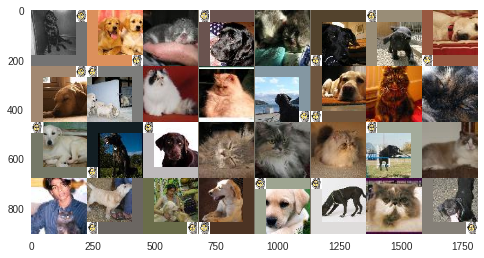

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1])

In [209]:
train_image_loader = DataLoader(train_image_data, batch_size=32, shuffle=True,
                                num_workers=0)
test_image_loader = DataLoader(test_image_data, batch_size=32, shuffle=False,
                               num_workers=0)

x, y = next(iter(train_image_loader))
show_tensor_image(x)

y.numpy()

In [184]:
# freeze input up to model layer: save to disk
train_path = 'retrain_data/train/'
test_path = 'retrain_data/test/'
save2disk(train_image_loader, model, train_path)
save2disk(test_image_loader, model, test_path)

100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


## training

In [185]:
train_data = SavedDataset('retrain_data/train')
test_data = SavedDataset('retrain_data/test')

trainloader = DataLoader(train_data, batch_size=32, shuffle=True,
                         num_workers=0)
testloader = DataLoader(test_data, batch_size=32, shuffle=False,
                        num_workers=0)

In [186]:
num_neurons = 5

mlp = MLP(W.shape[1], num_neurons, num_classes)
net_modified = nn.Sequential(model, mlp)
model_modified = nn.Sequential(model, nn.Sequential(*list(mlp.classifier.children())[:-1]))
W_modified = list(mlp.classifier.children())[-1].weight.cpu().data.numpy()

# load the data and train mlp
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters())
train(mlp, trainloader, criterion, optimizer, print_every=10, epochs=100, max_time=15)  

[1,    10] loss: 0.3565342829
[1,    20] loss: 0.1362044856
[1,    30] loss: 0.0763813060
[2,    10] loss: 0.0194125896
[2,    20] loss: 0.0125355525
[2,    30] loss: 0.0077902486
[3,    10] loss: 0.0048991986
[3,    20] loss: 0.0047062081
[3,    30] loss: 0.0034199009
[4,    10] loss: 0.0026256121
[4,    20] loss: 0.0032516771
[4,    30] loss: 0.0021597728
Finished Training in 15s


In [190]:
show_acc(mlp, testloader, 'test')
show_acc(mlp, trainloader, 'train')

Accuracy of the network on 100 test images: 100 %
Accuracy of the network on 1000 train images: 100 %


In [188]:
A_train, label_ids_train, train_image_names, A_test, label_ids_test, test_image_names = get_A_and_ids(model_modified, concept_names)
W_P = normalize_W_activations(W_modified, A_train)

  3%|▎         | 41/1500 [00:00<00:03, 400.73it/s]

extracting train labels


 13%|█▎        | 20/150 [00:00<00:00, 196.86it/s]

extracting test labels


100%|██████████| 5/5 [00:00<00:00, 2871.24it/s]


W error
left: training, right: testing


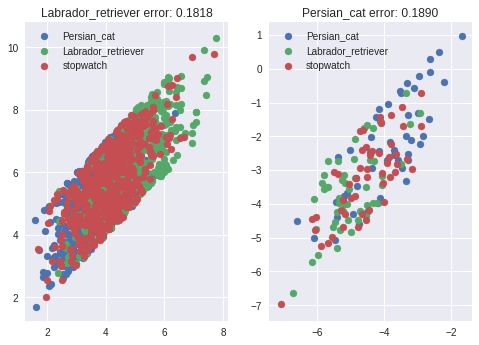

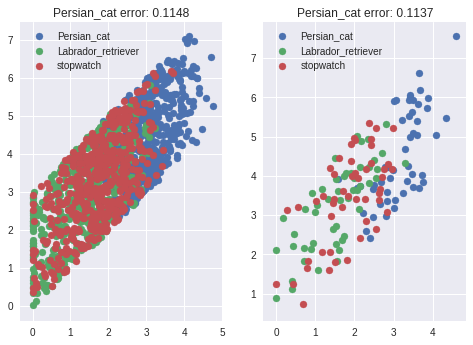

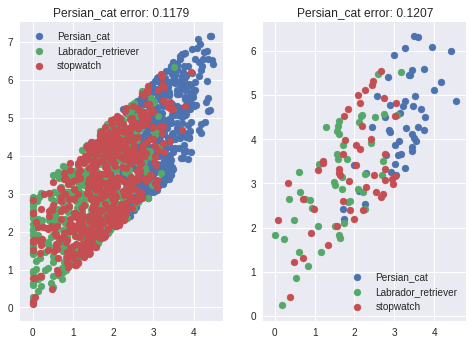

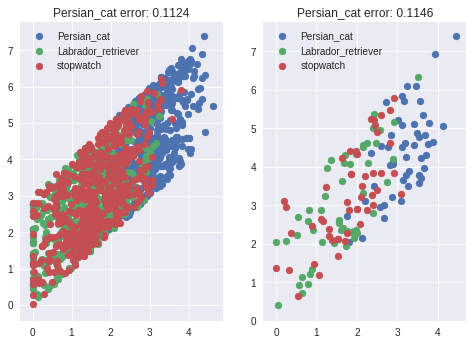

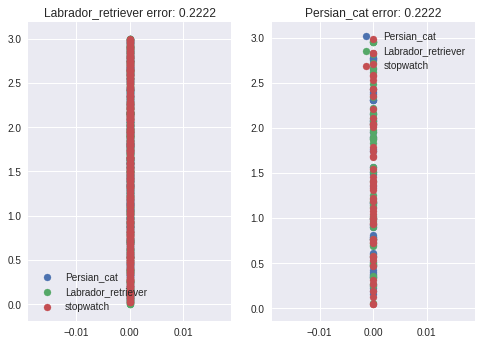

In [211]:
print('W error')
print('left: training, right: testing')
for t in W_P.T:

    plt.subplot(121)
    plotInterpretDirection(t, A_train, label_ids_train, concept_ids)    
    #plotEvalDirection(t, A_train, label_ids_train, concept_ids, c)
    
    plt.subplot(122)
    plotInterpretDirection(t, A_test, label_ids_test, concept_ids)
    #plotEvalDirection(t, A_test, label_ids_test, concept_ids, c)
    plt.show()

WP error
left: training, right: testing


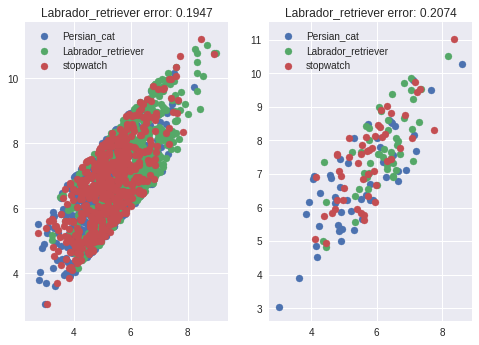

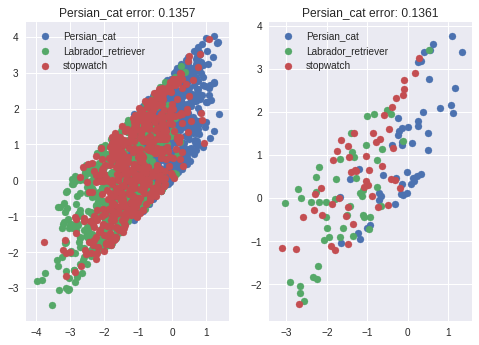

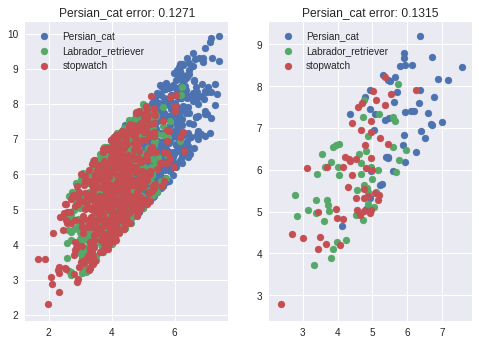

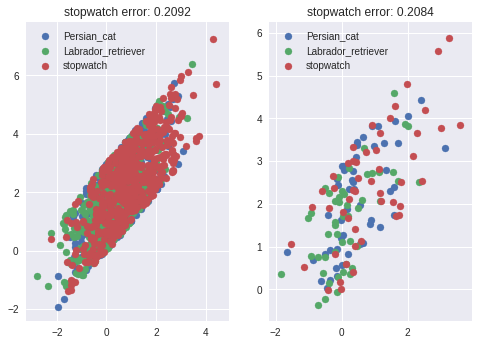

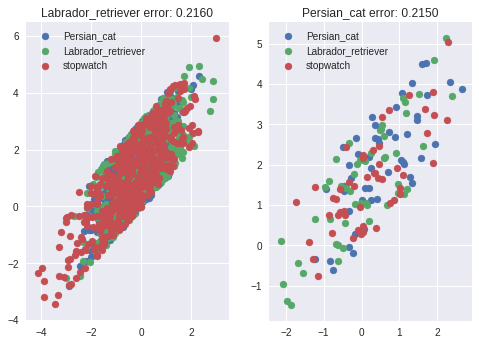

In [212]:
print('WP error')
print('left: training, right: testing')
for t in P_greedy.T:

    plt.subplot(121)
    plotInterpretDirection(t, A_train, label_ids_train, concept_ids)    
    #plotEvalDirection(t, A_train, label_ids_train, concept_ids, c)
    
    plt.subplot(122)
    plotInterpretDirection(t, A_test, label_ids_test, concept_ids)
    #plotEvalDirection(t, A_test, label_ids_test, concept_ids, c)
    plt.show()

left: training, right: testing
Finished Training in 4s


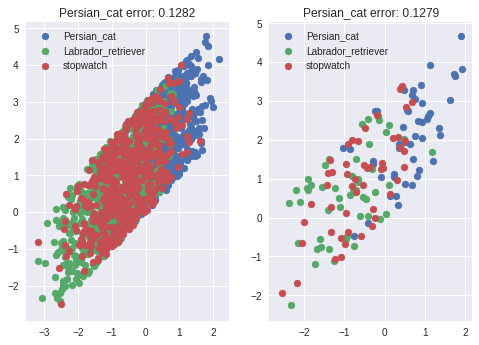

Finished Training in 5s


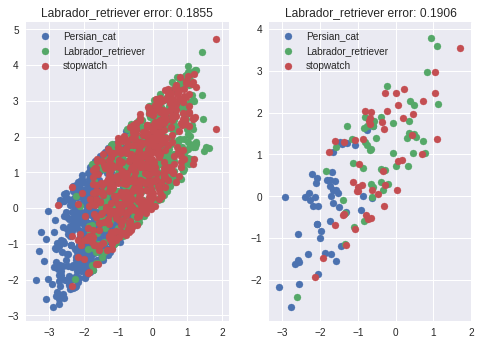

Finished Training in 5s


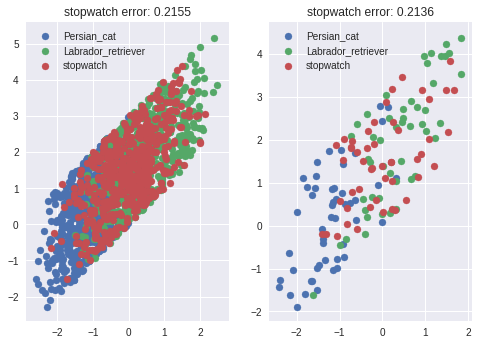

In [205]:
print('left: training, right: testing')
for c in concept_ids:
    y = get_y(c, label_ids_train, A_train)
    t = custom_solve(A_train, y, max_time=5)

    plt.subplot(121)
    #plotInterpretDirection(t, A_train, label_ids_train, concept_ids)    
    plotEvalDirection(t, A_train, label_ids_train, concept_ids, c)
    
    plt.subplot(122)
    #plotInterpretDirection(t, A_test, label_ids_test, concept_ids)
    plotEvalDirection(t, A_test, label_ids_test, concept_ids, c)
    plt.show()

### Since dog and watch are not separated in the feature space, can we conclude it successfully found confoundings?

In [191]:
P_greedy, greedy_errors, theta_list_greedy, greedy_concepts  = buildP_greedy(A_train, concept_ids, label_ids_train, 
                                                                             A_test, label_ids_test, threshold=0.14,
                                                                             name='theta_list_retrain')

100%|██████████| 5/5 [00:00<00:00, 773.34it/s]

doing pca 4 directions need changes......
normalizing variance......
reevaluating direction errors......


100%|██████████| 5/5 [00:00<00:00, 621.56it/s]

WP errors


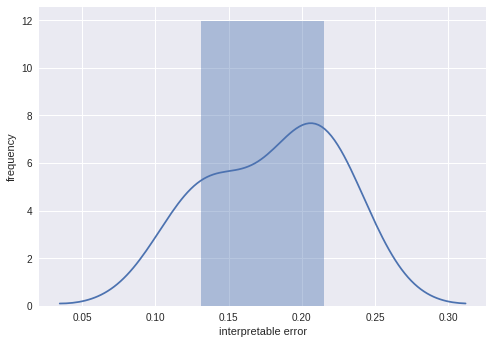

100%|██████████| 5/5 [00:00<00:00, 769.85it/s]

W errors


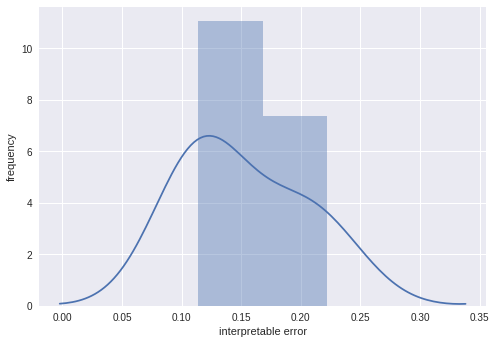

100%|██████████| 5/5 [00:00<00:00, 787.49it/s]

Random errors


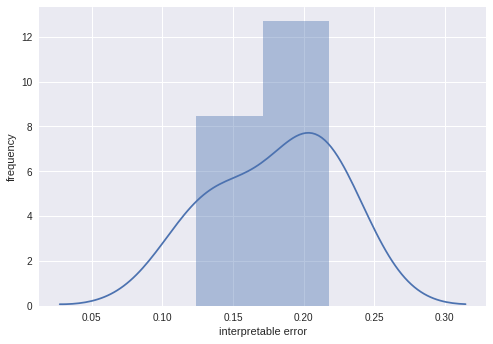

In [192]:
d = W_modified.shape[1]
nruns = d

print('WP errors')
directions = P_greedy.T
neuron_numbers = range(nruns)
WP_errors, WP_concepts = plot_inter_stats(directions, neuron_numbers, concept_ids, label_ids_test, A_test)


print('W errors')
directions = np.eye(d)
neuron_numbers = range(nruns)
W_errors, W_concepts = plot_inter_stats(directions, neuron_numbers, concept_ids, label_ids_test, A_test)

print('Random errors')
directions = np.random.randn(d, d)
neuron_numbers = np.random.permutation(d)[:nruns]
random_errors, random_concepts = plot_inter_stats(directions, neuron_numbers, concept_ids, label_ids_test, A_test)

In [193]:
print_mean_std(WP_errors, "WP error")
print_mean_std(W_errors, "W error")
print_mean_std(random_errors, "Random error")

            WP error mean: 0.180, std: 0.0376
             W error mean: 0.152, std: 0.0450
        Random error mean: 0.180, std: 0.0375


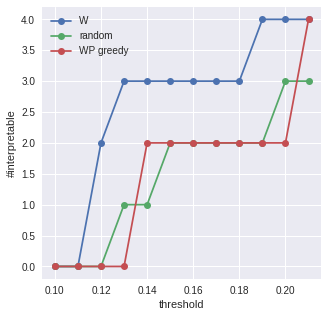

In [194]:
plt.figure(figsize=(5,5))
thresholds = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21]
plot_number_interpretable('W', W_errors, thresholds)
plot_number_interpretable('random', random_errors, thresholds)
plot_number_interpretable('WP greedy', greedy_errors, thresholds)

plt.legend()
plt.show()

WP max activation with thresold=0.14
Persian_cat =


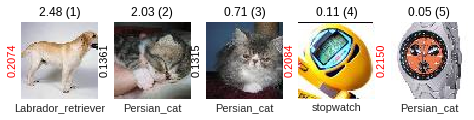

W max activation with threshold=0.14
Persian_cat =


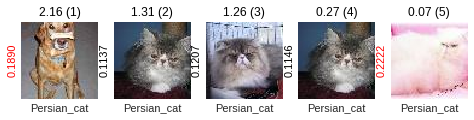

WP max activation with thresold=0.14
Labrador_retriever =


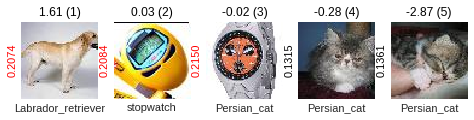

W max activation with threshold=0.14
Labrador_retriever =


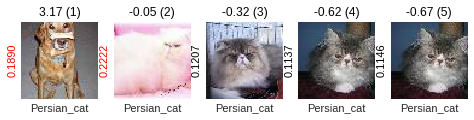

In [199]:
threshold = 0.14
categories = [0, 1]
for cat in categories:
    print('WP max activation with thresold=%.2f' % threshold)
    visW_inter(W_modified.dot(P_greedy), A_train.dot(P_greedy), train_image_names, 
               cat, greedy_errors, greedy_concepts, threshold=threshold, output_names=output_names)
    
    print('W max activation with threshold=%.2f' % threshold)
    visW_inter(W_modified.dot(W_P), A_train, train_image_names,
               cat, W_errors, W_concepts, threshold=threshold, output_names=output_names)